In [1]:
import librosa as lb
import librosa.display
import scipy
import json
import numpy as np
import sklearn
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import os
import keras
from keras.utils import np_utils
from keras import layers
from keras import models
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
from model_builder import build_example
from plotter import plot_history
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [8]:
# CONSTANTS

DATA_DIR = "openmic-2018/"
CATEGORY_COUNT = 8
LEARNING_RATE = 0.00001
THRESHOLD = 0.5

In [4]:
# LOAD DATA

OPENMIC = np.load(os.path.join(DATA_DIR, 'openmic-mel.npz'), allow_pickle=True)
print('OpenMIC keys: ' + str(list(OPENMIC.keys())))
X, Y_true, Y_mask, sample_key = OPENMIC['MEL'], OPENMIC['Y_true'], OPENMIC['Y_mask'], OPENMIC['sample_key']
print('X has shape: ' + str(X.shape))
print('Y_true has shape: ' + str(Y_true.shape))
print('Y_mask has shape: ' + str(Y_mask.shape))
print('sample_key has shape: ' + str(sample_key.shape))

OpenMIC keys: ['MEL', 'Y_true', 'Y_mask', 'sample_key']
X has shape: (20000, 128, 430)
Y_true has shape: (20000, 20)
Y_mask has shape: (20000, 20)
sample_key has shape: (20000,)


In [5]:
# LOAD LABELS

with open(os.path.join(DATA_DIR, 'class-map.json'), 'r') as f:
    INSTRUMENTS = json.load(f)
print('OpenMIC instruments: ' + str(INSTRUMENTS))

OpenMIC instruments: {'accordion': 0, 'banjo': 1, 'bass': 2, 'cello': 3, 'clarinet': 4, 'cymbals': 5, 'drums': 6, 'flute': 7, 'guitar': 8, 'mallet_percussion': 9, 'mandolin': 10, 'organ': 11, 'piano': 12, 'saxophone': 13, 'synthesizer': 14, 'trombone': 15, 'trumpet': 16, 'ukulele': 17, 'violin': 18, 'voice': 19}


In [6]:
# SPLIT DATA (TRAIN - TEST - VAL)

# CHANGE X TO MEL
split_train, split_test, X_train, X_test, Y_true_train, Y_true_test, Y_mask_train, Y_mask_test = train_test_split(sample_key, X, Y_true, Y_mask)
split_val, split_test, X_val, X_test, Y_true_val, Y_true_test, Y_mask_val, Y_mask_test = train_test_split(split_test, X_test, Y_true_test, Y_mask_test, test_size=0.5)
train_set = np.asarray(set(split_train))
test_set = np.asarray(set(split_test))
print('# Train: {}, # Val: {}, # Test: {}'.format(len(split_train), len(split_test), len(split_val)))

# Train: 15000, # Val: 2500, # Test: 2500


In [34]:
# DUPLICATE OF THE MODEL PREPROCESS

print(X_train.shape)
print(X_test.shape)

for instrument in INSTRUMENTS:
    
    # Map the instrument name to its column number
    inst_num = INSTRUMENTS[instrument]

    print(instrument)
    
    # TRAIN
    train_inst = Y_mask_train[:, inst_num]
    X_train_inst = X_train[train_inst]
    X_train_inst = X_train_inst.astype('float16')
    shape = X_train_inst.shape
    X_train_inst = X_train_inst.reshape(shape[0],1, shape[1], shape[2])
    Y_true_train_inst = Y_true_train[train_inst, inst_num] >= THRESHOLD
    i = 0
    for val in Y_true_train_inst:
        i += val
        
    print('TRAIN: ' + str(i) + ' true of ' + str(len(Y_true_train_inst)) + ' (' + str(round(i / len(Y_true_train_inst ) * 100,2)) + ' %)' )
        
    
    # TEST
    test_inst = Y_mask_test[:, inst_num]
    X_test_inst = X_test[test_inst]
    X_test_inst = X_test_inst.astype('float16')
    shape = X_test_inst.shape
    X_test_inst = X_test_inst.reshape(shape[0],1, shape[1], shape[2])
    Y_true_test_inst = Y_true_test[test_inst, inst_num] >= THRESHOLD
    
    i = 0
    for val in Y_true_test_inst:
        i += val
        
    print('TEST: ' + str(i) + ' true of ' + str(len(Y_true_test_inst)) + ' (' + str(round(i / len(Y_true_test_inst ) * 100,2)) + ' %)' )
    
    
    # VALIDATION
    val_inst = Y_mask_val[:, inst_num]
    X_val_inst = X_val[val_inst]
    X_val_inst = X_val_inst.astype('float16')
    shape = X_val_inst.shape
    X_val_inst = X_val_inst.reshape(shape[0],1, shape[1], shape[2])
    Y_true_val_inst = Y_true_val[val_inst, inst_num] >= THRESHOLD
    
    
    i = 0
    for val in Y_true_val_inst:
        i += val
    print('VALIDATION: ' + str(i) + ' true of ' + str(len(Y_true_val_inst)) + ' (' + str(round(i / len(Y_true_val_inst ) * 100,2)) + ' %)' )

(15000, 128, 430)
(2500, 128, 430)
accordion
TRAIN: 367 true of 1540 (23.83 %)
TEST: 64 true of 279 (22.94 %)
VALIDATION: 58 true of 252 (23.02 %)
banjo
TRAIN: 532 true of 1620 (32.84 %)
TEST: 99 true of 307 (32.25 %)
VALIDATION: 101 true of 291 (34.71 %)
bass
TRAIN: 410 true of 1401 (29.26 %)
TEST: 65 true of 234 (27.78 %)
VALIDATION: 74 true of 253 (29.25 %)
cello
TRAIN: 643 true of 1490 (43.15 %)
TEST: 97 true of 243 (39.92 %)
VALIDATION: 84 true of 216 (38.89 %)
clarinet
TRAIN: 411 true of 1810 (22.71 %)
TEST: 59 true of 293 (20.14 %)
VALIDATION: 63 true of 282 (22.34 %)
cymbals
TRAIN: 816 true of 1280 (63.75 %)
TEST: 144 true of 225 (64.0 %)
VALIDATION: 151 true of 230 (65.65 %)
drums
TRAIN: 827 true of 1313 (62.99 %)
TEST: 144 true of 226 (63.72 %)
VALIDATION: 135 true of 208 (64.9 %)
flute
TRAIN: 484 true of 1562 (30.99 %)
TEST: 82 true of 277 (29.6 %)
VALIDATION: 81 true of 245 (33.06 %)
guitar
TRAIN: 859 true of 1232 (69.72 %)
TEST: 147 true of 215 (68.37 %)
VALIDATION: 132 tr

In [15]:
# VALAMI FANCY ADATKIÍRÁS
len(Y_true_val_inst)


193

Train on 1520 samples, validate on 260 samples
Epoch 1/50
1520/1520 [==============================] - 353s 232ms/step - loss: 1.5777 - acc: 0.6349 - val_loss: 0.6895 - val_acc: 0.6500
Epoch 2/50
1520/1520 [==============================] - 359s 236ms/step - loss: 1.4950 - acc: 0.6454 - val_loss: 0.7613 - val_acc: 0.5308
Epoch 3/50
1520/1520 [==============================] - 391s 257ms/step - loss: 1.3114 - acc: 0.6408 - val_loss: 0.6520 - val_acc: 0.6577
Epoch 4/50
1520/1520 [==============================] - 378s 249ms/step - loss: 1.3263 - acc: 0.6388 - val_loss: 0.7163 - val_acc: 0.7308
Epoch 5/50
1520/1520 [==============================] - 383s 252ms/step - loss: 1.2001 - acc: 0.6553 - val_loss: 0.7212 - val_acc: 0.7308
Epoch 6/50
1520/1520 [==============================] - 364s 239ms/step - loss: 1.1281 - acc: 0.6724 - val_loss: 0.6261 - val_acc: 0.7192
Epoch 7/50
1520/1520 [==============================] - 368s 242ms/step - loss: 1.0747 - acc: 0.6572 - val_loss: 0.6214 - val

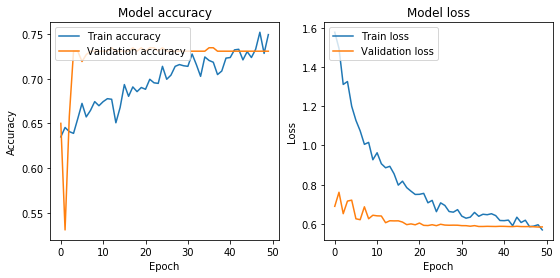

291/291 [==============================] - 25s 85ms/step
Test loss: 0.5564455607093077
Test accuracy: 76.98%
----------------------------------------------------
accordion
	TRAIN
              precision    recall  f1-score   support

       False       0.77      1.00      0.87      1168
        True       0.00      0.00      0.00       352

    accuracy                           0.77      1520
   macro avg       0.38      0.50      0.43      1520
weighted avg       0.59      0.77      0.67      1520

	TEST
              precision    recall  f1-score   support

       False       0.77      1.00      0.87       224
        True       0.00      0.00      0.00        67

    accuracy                           0.77       291
   macro avg       0.38      0.50      0.43       291
weighted avg       0.59      0.77      0.67       291



C:\Users\hjani\Documents\Conda\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Train on 1679 samples, validate on 271 samples
Epoch 1/50
1679/1679 [==============================] - 381s 227ms/step - loss: 1.8556 - acc: 0.5878 - val_loss: 0.8777 - val_acc: 0.3690
Epoch 2/50
1679/1679 [==============================] - 371s 221ms/step - loss: 1.0476 - acc: 0.5926 - val_loss: 0.8169 - val_acc: 0.3801
Epoch 3/50
1679/1679 [==============================] - 371s 221ms/step - loss: 1.1032 - acc: 0.5753 - val_loss: 0.8527 - val_acc: 0.3690
Epoch 4/50
1679/1679 [==============================] - 370s 220ms/step - loss: 1.0434 - acc: 0.5896 - val_loss: 0.8618 - val_acc: 0.3653
Epoch 5/50
1679/1679 [==============================] - 373s 222ms/step - loss: 1.0396 - acc: 0.5694 - val_loss: 0.8500 - val_acc: 0.3727
Epoch 6/50
1679/1679 [==============================] - 370s 221ms/step - loss: 0.9761 - acc: 0.5825 - val_loss: 0.7623 - val_acc: 0.3875
Epoch 7/50
1679/1679 [==============================] - 370s 221ms/step - loss: 0.9765 - acc: 0.5736 - val_loss: 0.7785 - val

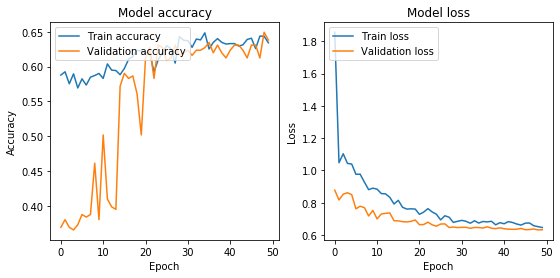

268/268 [==============================] - 22s 81ms/step
Test loss: 0.6290143612605422
Test accuracy: 65.67%
----------------------------------------------------
banjo
	TRAIN
              precision    recall  f1-score   support

       False       0.69      0.93      0.79      1133
        True       0.49      0.13      0.21       546

    accuracy                           0.67      1679
   macro avg       0.59      0.53      0.50      1679
weighted avg       0.63      0.67      0.60      1679

	TEST
              precision    recall  f1-score   support

       False       0.68      0.92      0.78       179
        True       0.44      0.13      0.21        89

    accuracy                           0.66       268
   macro avg       0.56      0.53      0.49       268
weighted avg       0.60      0.66      0.59       268

Train on 1425 samples, validate on 226 samples
Epoch 1/50
1425/1425 [==============================] - 317s 222ms/step - loss: 1.4996 - acc: 0.6070 - val_loss: 0.930

In [ ]:
from keras.optimizers import SGD
# This dictionary will include the classifiers for each model
mymodels = dict()
# We'll iterate over all istrument classes, and fit a model for each one
# After training, we'll print a classification report for each instrument
for instrument in INSTRUMENTS:
    
    # Map the instrument name to its column number
    inst_num = INSTRUMENTS[instrument]

    # Step 1: sub-sample the data
    # First, we need to select down to the data for which we have annotations
    # This is what the mask arrays are for
    # Here, we're using the Y_mask_train array to slice out only the training examples
    # for which we have annotations for the given class
    # Again, we slice the labels to the annotated examples
    # We thresold the label likelihoods at 0.5 to get binary labels
    
    # TRAIN
    train_inst = Y_mask_train[:, inst_num]
    X_train_inst = X_train[train_inst]
    X_train_inst = X_train_inst.astype('float16')
    shape = X_train_inst.shape
    X_train_inst = X_train_inst.reshape(shape[0],1, shape[1], shape[2])
    Y_true_train_inst = Y_true_train[train_inst, inst_num] >= THRESHOLD
    
    # TEST
    test_inst = Y_mask_test[:, inst_num]
    X_test_inst = X_test[test_inst]
    X_test_inst = X_test_inst.astype('float16')
    shape = X_test_inst.shape
    X_test_inst = X_test_inst.reshape(shape[0],1, shape[1], shape[2])
    Y_true_test_inst = Y_true_test[test_inst, inst_num] >= THRESHOLD
    
    # VALIDATION
    val_inst = Y_mask_val[:, inst_num]
    X_val_inst = X_val[val_inst]
    X_val_inst = X_val_inst.astype('float16')
    shape = X_val_inst.shape
    X_val_inst = X_val_inst.reshape(shape[0],1, shape[1], shape[2])
    Y_true_val_inst = Y_true_val[val_inst, inst_num] >= THRESHOLD
    

    # Step 3.
    # Initialize a new classifier
    model = models.Sequential()
    model.add(Conv2D(input_shape=(1,128,430),data_format="channels_first",filters=32,kernel_size=(3,3),padding="same", activation="relu"))
    model.add(Conv2D(filters=32,kernel_size=(3,3),padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(3,3),strides=(2,2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(units=512, activation='relu'))
    model.add(layers.Dense(units=256, activation='relu'))
    model.add(layers.Dense(units=1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer=SGD(lr=0.00001), metrics = ['accuracy'])

    # model.summary()
    # Step 4.
    history = model.fit(X_train_inst,Y_true_train_inst , epochs=50, batch_size=32, validation_data=(X_val_inst,Y_true_val_inst))
    
    plot_history()
    
    loss, acc = model.evaluate(X_test_inst, Y_true_test_inst)
    print('Test loss: {}'.format(loss))
    print('Test accuracy: {:.2%}'.format(acc))
    # Step 5.
    # Finally, we'll evaluate the model on both train and test
    Y_pred_train = model.predict(X_train_inst)
    Y_pred_test = model.predict(X_test_inst)
    Y_pred_train_bool = Y_pred_train > THRESHOLD #THRESHOLD (should be lower than 0.5)
    Y_pred_test_bool = Y_pred_test > THRESHOLD #THRESHOLD (should be lower than 0.5)
    print('-' * 52)
    print(instrument)
    print('\tTRAIN')
    print(classification_report(Y_true_train_inst, Y_pred_train_bool))
    print('\tTEST')
    print(classification_report(Y_true_test_inst, Y_pred_test_bool))

    # Store the classifier in our dictionary
mymodels[instrument] = model

In [10]:

import matplotlib.pyplot as plt
from pylab import plot, show, figure, imshow, xlim, ylim, title


def plot_history():
    plt.figure(figsize=(9,4))
    plt.subplot(1,2,1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train accuracy', 'Validation accuracy'], loc='upper left')
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper left')
    plt.show()

In [ ]:
""""
    # Step 3: simplify the data by averaging over time
    # Instead of having time-varying features, we'll summarize each track by its mean feature vector over time
    X_train_inst_sklearn = np.mean(X_train_inst, axis=1)
    X_test_inst_sklearn = np.mean(X_test_inst, axis=1)
    X_train_inst_sklearn = X_train_inst_sklearn.astype('float32')
    X_train_inst_sklearn = lb.util.normalize(X_train_inst_sklearn)
"""

np.savez('models.npz',model=)